Loaded data: (230, 16)


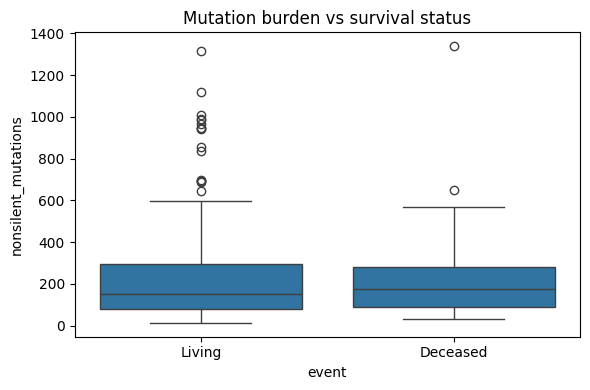

Model matrix: (229, 73)
ROC AUC: 0.806
CV AUC: 0.721 ± 0.044
                feature      coef  odds_ratio
49          t_stage_T2a -1.503151    0.222428
28  age_at_diagnosis_70 -1.407159    0.244838
30  age_at_diagnosis_72  1.110978    3.037328
55           n_stage_N1  1.003459    2.727701
47          t_stage_T1b -0.977002    0.376438
13  age_at_diagnosis_55 -0.975308    0.377076
48           t_stage_T2  0.968732    2.634602
18  age_at_diagnosis_60 -0.841994    0.430851
52           t_stage_T4  0.789793    2.202940
3   age_at_diagnosis_45  0.782695    2.187358


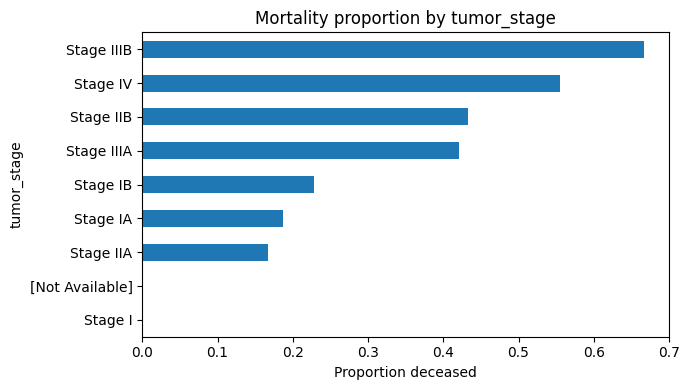

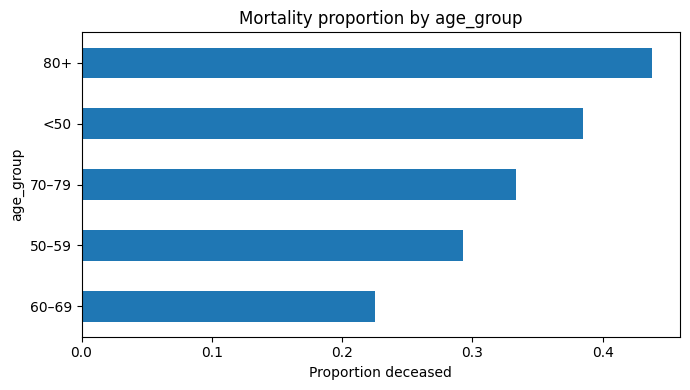

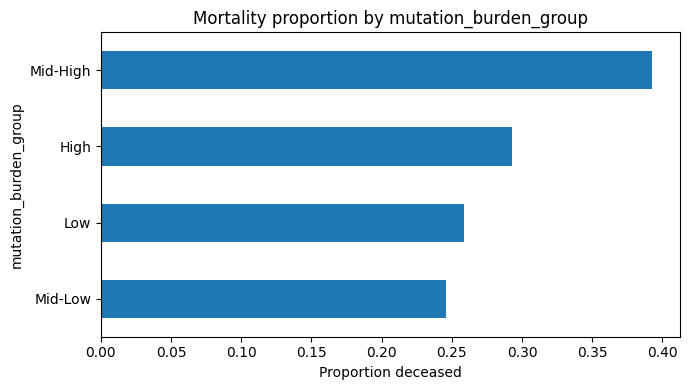

In [30]:
# ===============================
# Imports
# ===============================
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


# ===============================
# Config
# ===============================
DATA_PATH = Path("../data/processed/clinical_genomic_clean.csv")


# ===============================
# Utility functions
# ===============================
def load_data(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Data not found at {path}")
    df = pd.read_csv(path)
    print("Loaded data:", df.shape)
    return df


def plot_mutation_burden_vs_event(df):
    plt.figure(figsize=(6, 4))
    sns.boxplot(x="event", y="nonsilent_mutations", data=df)
    plt.xticks([0, 1], ["Living", "Deceased"])
    plt.title("Mutation burden vs survival status")
    plt.tight_layout()
    plt.show()


def add_age_groups(
    df,
    age_col="age_at_diagnosis",
    new_col="age_group"
):
    df = df.copy()
    df[age_col] = pd.to_numeric(df[age_col], errors="coerce")
    df[new_col] = pd.cut(
        df[age_col],
        bins=[0, 50, 60, 70, 80, 120],
        labels=["<50", "50–59", "60–69", "70–79", "80+"],
        right=False
    )
    return df


def add_mutation_burden_groups(
    df,
    col="nonsilent_mutations",
    new_col="mutation_burden_group"
):
    df = df.copy()
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[new_col] = pd.qcut(
        df[col],
        q=4,
        labels=["Low", "Mid-Low", "Mid-High", "High"]
    )
    return df


# ===============================
# Modeling class
# ===============================
class LogisticMortalityModel:
    def __init__(self, features, event_col="event"):
        self.features = features
        self.event_col = event_col
        self.model = LogisticRegression(max_iter=1000)
        self.X = None
        self.y = None

    def prepare_data(self, df):
        df_model = df[self.features + [self.event_col]].dropna()
        self.X = pd.get_dummies(
            df_model.drop(columns=self.event_col),
            drop_first=True
        )
        self.y = df_model[self.event_col]
        print("Model matrix:", self.X.shape)
        return self.X, self.y

    def fit(self, test_size=0.3, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(
            self.X,
            self.y,
            test_size=test_size,
            stratify=self.y,
            random_state=random_state
        )
        self.model.fit(X_train, y_train)
        y_pred = self.model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        print(f"ROC AUC: {auc:.3f}")
        return auc

    def cross_validated_auc(self, n_splits=5):
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        aucs = []
        for train_idx, test_idx in cv.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_idx], self.X.iloc[test_idx]
            y_train, y_test = self.y.iloc[train_idx], self.y.iloc[test_idx]
            self.model.fit(X_train, y_train)
            y_pred = self.model.predict_proba(X_test)[:, 1]
            aucs.append(roc_auc_score(y_test, y_pred))
        print(f"CV AUC: {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
        return aucs

    def coefficients(self):
        coef_df = (
            pd.DataFrame({
                "feature": self.X.columns,
                "coef": self.model.coef_[0]
            })
            .assign(odds_ratio=lambda d: np.exp(d["coef"]))
            .sort_values("coef", key=np.abs, ascending=False)
        )
        return coef_df


# ===============================
# Crosstab analysis class
# ===============================
class MortalityCrosstabAnalyzer:
    def __init__(self, df, event_col="event"):
        self.df = df.copy()
        self.event_col = event_col

    def crosstab_counts(self, feature):
        return pd.crosstab(
            self.df[feature],
            self.df[self.event_col],
            margins=True
        )

    def crosstab_row_percent(self, feature):
        return (
            pd.crosstab(
                self.df[feature],
                self.df[self.event_col],
                normalize="index"
            )
            .round(3)
        )

    def plot_mortality_proportion(self, feature):
        ct = pd.crosstab(
            self.df[feature],
            self.df[self.event_col],
            normalize="index"
        )
        ct[1].sort_values().plot(kind="barh", figsize=(7, 4))
        plt.xlabel("Proportion deceased")
        plt.title(f"Mortality proportion by {feature}")
        plt.tight_layout()
        plt.show()


# ===============================
# Main workflow
# ===============================
if __name__ == "__main__":

    # Load data
    df = load_data(DATA_PATH)

    # EDA
    plot_mutation_burden_vs_event(df)

    # Feature list
    features = [
        "age_at_diagnosis",
        "nonsilent_mutations",
        "t_stage",
        "n_stage",
        "tumor_stage",
        "smoking_status",
        "oncogene_negative_or_positive_groups"
    ]

    # Modeling
    modeler = LogisticMortalityModel(features)
    modeler.prepare_data(df)
    modeler.fit()
    modeler.cross_validated_auc()

    coef_df = modeler.coefficients()
    print(coef_df.head(10))

    # Save coefficients
    out_path = Path("../data/processed/logistic_coefficients.csv")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    coef_df.to_csv(out_path, index=False)

    # Crosstab analysis
    df = add_age_groups(df)
    df = add_mutation_burden_groups(df)

    analyzer = MortalityCrosstabAnalyzer(df)

    analyzer.plot_mortality_proportion("tumor_stage")
    analyzer.plot_mortality_proportion("age_group")
    analyzer.plot_mortality_proportion("mutation_burden_group")
